In [70]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [187]:
from stompy import utils
import six
import shutil
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
import subprocess
import os
%matplotlib notebook

In [72]:
import logging
log = logging.getLogger()

import re, os, six
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import xarray as xr

import numpy as np
import pandas as pd

from stompy.memoize import memoize
from stompy.grid import unstructured_grid
from stompy import utils, filters
from stompy.plot import plot_wkb

In [139]:
runs=[]
runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dfm_swim_and_point_20220810/"
                                     "DFM_OUTPUT_wy2022_bloom_16layer/"
                                     "wy2022_bloom_16layer_20220501_000000_map.nc"),
                  run_dir="run_wy2022_16layer_dfm_swim_and_point_20220810",
                  model='DFM',
                  model_version='2023.01',
                  blob_tracer='blob',
                  swim_tracer='swim',
                  label='DFM'))
if 0:
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v009/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v009",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 15.60'))
    
if 1:
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v011/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v011",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 16.62'))
    
if 0:
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v012/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v012",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 16.62 nu_v=0'))
    
if 1:
    # Integration option 21
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v013/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v013",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 21'))

if 1:
    # Integration option 22
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v015/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v015",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 22'))

if 1:
    # Integration option 24. This was very fast! 970x realtime, compared 200x realtime for 21.
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v014/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v014",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 24'))
    
if 1:
    # Integration option 16, but short time step
    runs.append( dict(ds=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v016/dwaq_map.nc"),
                      model='DWAQ',
                      run_dir="run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v016",
                      model_version='2023.01',
                      blob_tracer='dye1',
                      swim_tracer='BLOOMAlg01',
                      label='DWAQ 16, dt=60s'))


In [140]:
for run in runs:
    run['grid']=unstructured_grid.UnstructuredGrid.read_ugrid(run['ds'])
poly=runs[0]['grid'].boundary_polygon()


INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


Compare Blobs
==

In [111]:
import ipywidgets as ipw

<IPython.core.display.Javascript object>


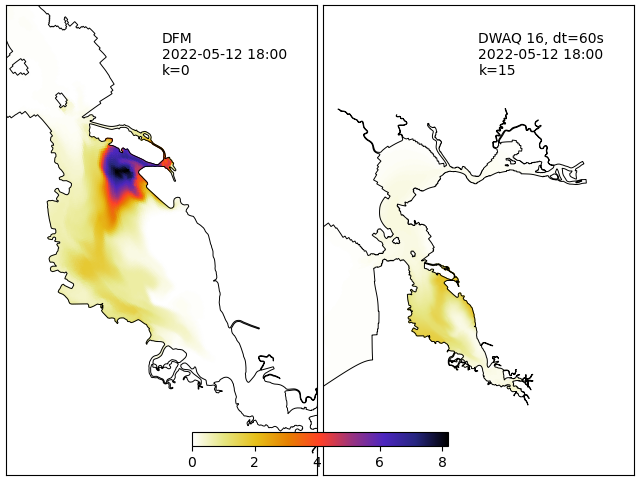

interactive(children=(IntSlider(value=0, description='tidx0', max=96), IntSlider(value=0, description='dfm_lay…

<function __main__.plot(tidx0=10, dfm_layer=15)>

In [113]:
plot_runs=runs[:2]

fig,axs=plt.subplots(1,len(plot_runs))

for ax in axs:
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    ax.set_adjustable('datalim')
    
cax=fig.add_axes([0.3,0.07,0.4,0.03])

Nlayers=plot_runs[0]['ds'].dims['laydim']
fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,wspace=0.02)

def plot(tidx0=10,dfm_layer=Nlayers-1): 
    for ax,run in zip(axs,plot_runs): 
        ds=run['ds']
        ax.cla()
        plot_wkb.plot_wkb(poly,facecolor='none',lw=0.7,edgecolor='k',ax=ax,zorder=4)
        if run is runs[0]:
            # First run dictates time steps
            tidx=tidx0
            t0=ds.time.values[tidx]
        else:
            tidx=np.searchsorted(ds.time.values,t0)
            
        if run['model']=='DFM':
            k=dfm_layer
            sel=dict(laydim=k)
        else:
            k=Nlayers-(1+dfm_layer)
            sel=dict(layer=k)

        scal=ds[run['blob_tracer']].isel(time=tidx,**sel).values
        if run is runs[0]:
            clim=[0,scal.max()]
        t=ds.time.values[tidx]

        coll=run['grid'].plot_cells(values=scal,
                                    cmap="CMRmap_r",
                                    lw=0.5,edgecolor='face', clim=clim,ax=ax)
        t_str=utils.to_datetime(t).strftime("%Y-%m-%d %H:%M")
        ax.text(0.5,0.85,f"{run['label']}\n{t_str}\nk={k}",transform=ax.transAxes)
    plt.colorbar(coll,cax=cax,orientation='horizontal')

    for ax in axs:
        ax.axis('equal')
        ax.axis((548382.9844699897, 587609.3817548773, 4145278.545893392, 4192399.4642829127))
    plt.draw()
    
plot()

ipw.interact(plot,
             tidx0 = ipw.IntSlider(min=0,max=runs[0]['ds'].dims['time']-1,step=1),
             dfm_layer = ipw.IntSlider(min=0,max=Nlayers-1,step=1) )
    

<IPython.core.display.Javascript object>


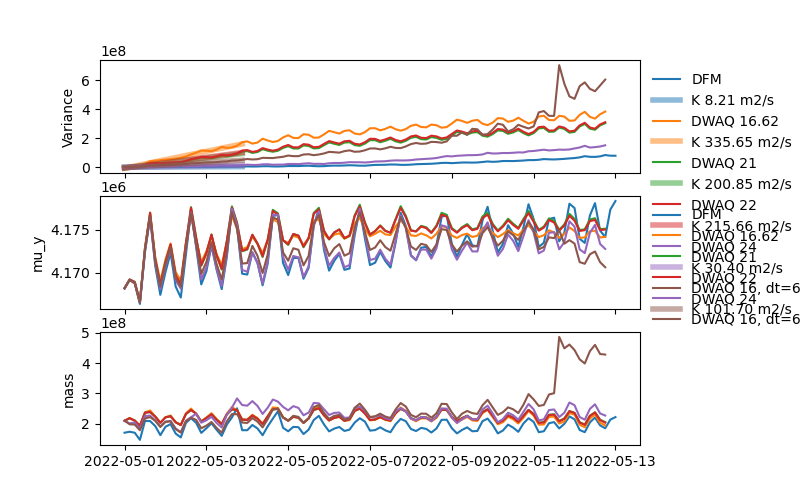

In [184]:
# Growth of variance
fig,axs=plt.subplots(3,1,sharex=True,figsize=(8,5))

t_diff=np.timedelta64(3,'D') # time over which to fit diffusion coeff.

for run in runs:
    cc=run['grid'].cells_center()
    ds=run['ds']
    
    times=[]
    var_tot=[]
    centroids=[]
    if len(axs)>2:
        mass=[]
    else:
        mass=None

    for tidx in utils.progress(range(run['ds'].dims['time'])):
        times.append(ds.time.values[tidx])
        scal=ds[run['blob_tracer']].isel(time=tidx)
        if run['model']=='DFM':
            layer='laydim'
            snap=ds.isel(time=-1)
            volumes=(snap['s1'] - snap['FlowElem_bl'])*snap['FlowElem_bac']/snap.dims['laydim']            
        else:
            layer='layer'
            snap=ds.isel(time=-1)
            volumes=(snap['SURF']*snap['TotalDepth']).isel(layer=0)/snap.dims['layer']
        scal=scal.mean(dim=layer).values.clip(0)
        scal[np.isnan(scal)]=0.0

        # Get the centroid. Before I was ignoring differences in volume.
        masses=volumes.values*scal
        total_mass=masses.sum()
        
        scal_centroid=(cc * masses[:,None]).sum(axis=0) / total_mass
        C=np.cov( cc.T, aweights=masses, ddof=0)
        var_tot.append(np.trace(C))
        centroids.append(scal_centroid)
        
        # Get total mass:
        if mass is not None:
            mass.append(total_mass) 
    
    times=np.array(times)
    var_tots=np.array(var_tot)
    centroids=np.array(centroids)
    
    ls = axs[0].plot(times,var_tots,label=run['label'])
    axs[1].plot(times,centroids[:,1],label=run['label'])
    if mass is not None:
        mass=np.array(mass)
        axs[2].plot(times,mass,label=run['label'])
    
    # Fit diffusion coefficient, however flawed, to the first
    # 5 days.
    diff_sel=times<times[0]+t_diff
    t_dn=utils.to_dnum(times[diff_sel])
    m,b=np.polyfit( t_dn, var_tots[diff_sel],1)
    K=0.5*m/86400. # m2/s.
    axs[0].plot(times[diff_sel], np.polyval([m,b],t_dn),label=f'K {K:.2f} m2/s',
                color=ls[0].get_color(),ls='-',lw=4,alpha=0.5)
    run['K']=K
    
axs[0].set_ylabel('Variance')
axs[1].set_ylabel('mu_y')
if mass is not None:
    axs[2].set_ylabel('mass')

axs[0].legend(loc='upper left',bbox_to_anchor=[1.0,1.0],frameon=0)
axs[1].legend(loc='upper left',bbox_to_anchor=[1.0,1.0],frameon=0)
fig.subplots_adjust(right=0.80)

In [185]:
# How to get the run time?
for run in runs:
    if run['model']=='DFM':
        run_dir=run['run_dir']
        model=dfm.DFlowModel.load(run_dir)
        stats=model.timing_stats()
        run['speed']=stats['sim_time_completed'] / stats['wall_time_completed'] 
    elif run['model']=='DWAQ':
        # just compare timestamps of files
        lsp_file=os.path.join(run['run_dir'],"waqmodel.lsp")
        map_file=os.path.join(run['run_dir'],"waqmodel.map")
        wall_time=os.stat(map_file).st_mtime - os.stat(lsp_file).st_mtime
        sim_time=run['ds'].time.values[-1] - run['ds'].time.values[0]
        run['speed'] = (sim_time/np.timedelta64(1,'s'))/wall_time 

In [186]:
import pandas as pd
runs_df=pd.DataFrame(runs)
runs_df[ ['model','label','speed','K']]

,model,label,speed,K
0,DFM,DFM,7.295038,8.209054
1,DWAQ,DWAQ 16.62,212.553599,335.652943
2,DWAQ,DWAQ 21,220.930499,200.849655
3,DWAQ,DWAQ 22,226.375752,215.660148
4,DWAQ,DWAQ 24,951.161880,30.396550
5,DWAQ,"DWAQ 16, dt=60s",50.551288,101.700788
